# Challenge : Humpback Whale Identification

> Ce Challenge de Kaggle qui a pour destination l'identification du nom de baleines d√©j√† identifi√©es (et "labelis√©es")
    - Dans le cas o√π celle-ci n'est pas 'connue' elle doit √™tre cat√©goris√©e comme √©tant `new_whale`
Le fichier de soumission doit contenir le nom de l'image de test ainsi que 5 pr√©dictions de noms de baleines<br>
Le fait d'ajouter un 2e, 3e ... nom ne p√©nalise pas plus, il est donc souhaitable de remplir les 5 noms possibles.<br>
Le r√©sultat prend en compte l'ordre de pr√©diction des noms
    - le bon nom de classe propos√© en 1e position obtiendra 1 
    - le bon nom est en position 2 : 1/2
    - en 3 : 1/3
    - en 4 : 1/4
    - en 5 : 1/5
C'est la moyenne des notes de toutes les images qui est la mesure de performance

<div class="alert alert-block alert-warning">
$$MAP@5=\frac{1}{U}\sum_{u=1}^{U}\sum_{k=1}^{min(n,5)}P(k)√órel(k)$$<br>
<center>o√π</center>
- U est le nombre d'images<br>
- P(k) est la pr√©cision √† l'index k<br>
- n le nombre de pr√©diction pour l'image<br>
- rel(k) la fonction indicatrice qui vaut 1 si le label √† la position k est juste 0 sinon<br>
</div>


<div class="alert alert-block alert-success">
<b>Tests Naifs:</b>
<br>Des tests na√Øfs de soumission de fichiers de r√©sultats ont √©t√© faits et rel√®vent ainsi<br>
1. Soumission_V0 : Reprise du fichier d'origine avec les noms des bonnes images -> `0.277 [place 1759]`<br>
    &nbsp;&nbsp;&nbsp;   'new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c' pour chaque image<br>
2. Soumission_V1 : Le fichier reprend new_whale en 2e position -> `0.139`<br>
    &nbsp;&nbsp;&nbsp;    'w_23a388d new_whale w_9b5109b w_9c506f6 w_0369a5c'<br>
<br>
<b>A cette heure :</b><br> 
- 1981 participants<br>
--> Les notes se basent sur seulement 20 % des donn√©es du fichier de soumission</div>

# PLAN

<h2><font color=blue>[1. Exploration des Donn√©es](#section1)</font></h2><br>
1. [D√©couverte des donn√©es](#section1.1)<br>
1. [Visualisation des Images](#section1.2)<br>
1. [R√©partition des Donn√©es](#section1.3)<br>
    
<h2><font color=blue>[2. Probl√®mes soulev√©s par ce Challenge](#section2)</font></h2><br>
1. [La probl√©matique G√©n√©rale du KAGGLE](#section2.1)<br>
    1. [Strat√©gie Globale](#section2.1.1)<br>
    1. [Strat√©gie particuli√®res](#section2.1.2)<br>
1. [Les Difficult√©s li√©es aux donn√©es](#section2.2)<br>
    1. [Transfer Learning](#section2.2.1)<br>
    1. [Data Augmentation](#section2.2.2)<br>

<h2><font color=blue>[3. La Mod√©lisation](#section3)</font></h2><br>
1. [CNN](#section3.1)<br>
1. [Process](#section3.2)<br>
1. [Pr√©-Traitement sur les Images](#section3.3)<br>

<h2><font color=blue>[4. Les R√©sultats de la mod√©lisation](#section4)</font></h2><br>
1. [L'entrainement](#section4.1)<br>
1. [Les R√©sultats](#section4.2)<br>
1. [Faux Bon r√©sultat](#section4.3)<br>

<h2><font color=blue>[5. CONCLUSION](#section5)</font></h2><br>

<a id='section1'></a>

# Exploration des Donn√©es

In [1]:
dir_data = './../DATAS/data/'

dir_image_train = dir_data + 'train/'
dir_image_test = dir_data + 'test/'
csv_file = dir_data + 'train.csv'

#### Librairies 

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
## Fonctions Utiles
from keras.preprocessing.image import ImageDataGenerator, image
from Utils import TransformImage

Using TensorFlow backend.


<a id='section1.1'></a>

## D√©couverte des Donn√©es

In [5]:
df_train = pd.read_csv(csv_file)
df_train.head()

Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale

In [6]:
df_train.shape, len(os.listdir(dir_image_train)), len(os.listdir(dir_image_test))

((25361, 2), 25361, 7960)

In [7]:
len(set(list(df_train.Image))-set(os.listdir(dir_image_train)))

0

> Nous avons donc 25 361 images dans le r√©pertoire d'entrainement, avec les m√™mes noms d'images que celles du fichier 'train.csv' 

> Nous avons 7 960 images dans le r√©pertoire de test pour g√©n√©rer les fichiers de soumission

<a id='section1.2'></a>
## Visualisation des Images
-----

In [8]:
df_train.head()

Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale

In [15]:
def image_with_index(idx):
    return np.array(image.load_img(dir_image_train + df_train.loc[idx].Image))

def image_name_id_from_index(idx):
    val = df_train.loc[idx]
    return '{} / {}'.format(val['Image'], val['Id'])

def get_image_name_id_from_index(idx):
    return df_train.loc[idx]['Image']

def image_with_name(image_name):
    return np.array(image.load_img(dir_image_train + image_name))

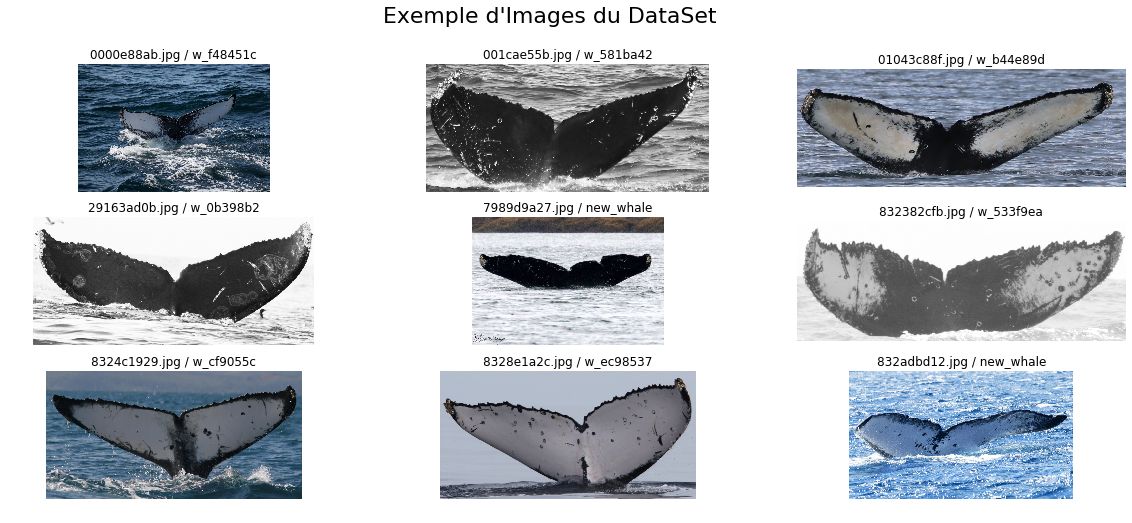

In [10]:
l_index_image_dataSet = [0, 10, 100, 4000, 12000, 13000, 13001, 13002, 13003]

fig, ax = plt.subplots(3, 3, figsize=(20, 8))
ax = ax.ravel()

for idx_axe, idx_image in enumerate(l_index_image_dataSet):
    ax[idx_axe].imshow(image_with_index(idx_image))
    ax[idx_axe].axis('off')
    ax[idx_axe].set_title(image_name_id_from_index(idx_image))

plt.suptitle("Exemple d'Images du DataSet", fontsize=22)
plt.show()

> Regardons des Images appartenant √† la m√™me classe

<a id='section1.3'></a>
## R√©partition des Donn√©es
-----
> Nous allons regarder la distribution des donn√©es en fr√©quence

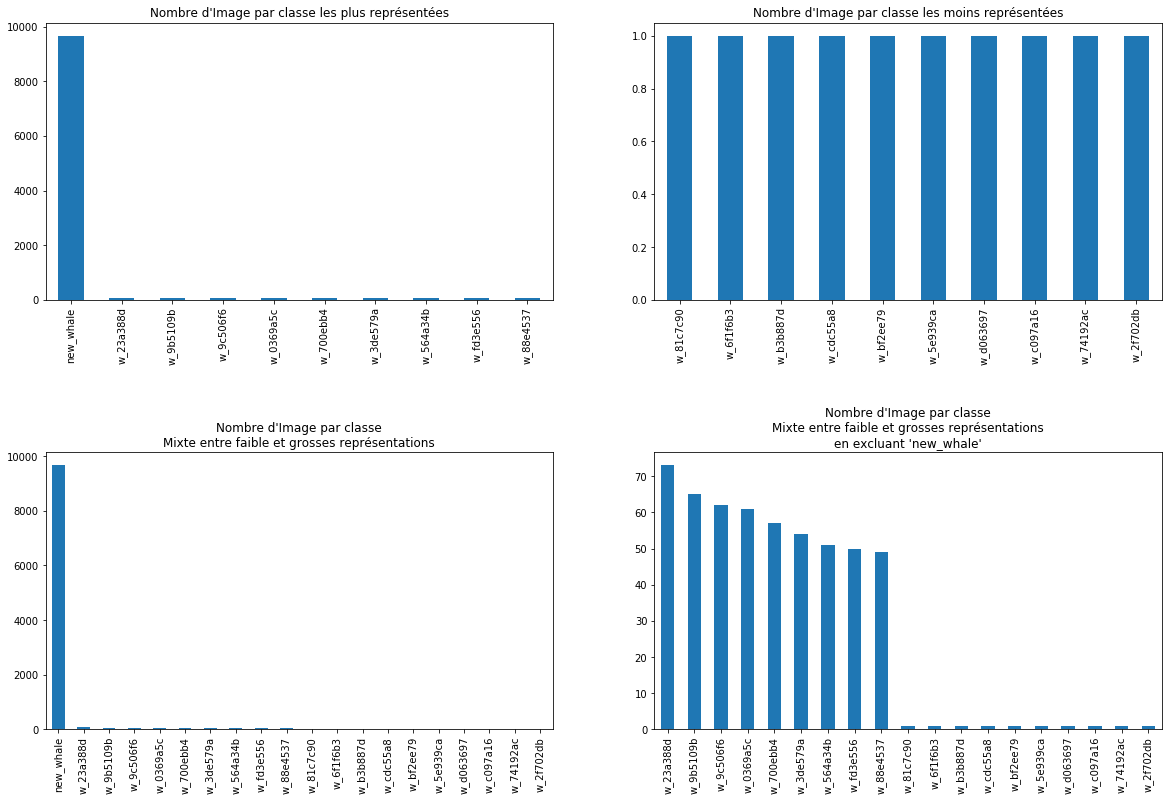

In [11]:
Head = df_train.Id.value_counts().sort_values(ascending=False).head(10)
Tail = df_train.Id.value_counts().sort_values(ascending=False).tail(10)
All = df_train.Id.value_counts().sort_values(ascending=False)
t2 = pd.concat([Head, Tail])

fig, ax = plt.subplots(2, 2, figsize=(20, 13))
fig.subplots_adjust(hspace=0.55)
ax = ax.ravel()

u1 = Head.plot(kind='bar', ax=ax[0],  title="Nombre d'Image par classe les plus repr√©sent√©es")
Tail.plot(kind='bar', ax=ax[1], title="Nombre d'Image par classe les moins repr√©sent√©es")
t2.plot(kind='bar', ax=ax[2],  title="Nombre d'Image par classe\nMixte entre faible et grosses repr√©sentations")
t2[t2.values<2000].plot(kind='bar', ax=ax[3],  title="Nombre d'Image par classe\n"
                        "Mixte entre faible et grosses repr√©sentations\nen excluant 'new_whale'")

plt.show()

In [302]:
def affiche_exemple_image_meme_class(CLASS_NAME):
    l_index_image_dataSet = list(df_train[df_train.Id==CLASS_NAME].index[:3])

    fig, ax = plt.subplots(1, 3, )
    fig.set_size_inches(15, 4, forward=True)
    ax = ax.ravel()

    for idx_axe, idx_image in enumerate(l_index_image_dataSet):
        ax[idx_axe].imshow(image_with_index(idx_image))
        ax[idx_axe].axis('off')
        ax[idx_axe].set_title(image_name_id_from_index(idx_image))

    plt.suptitle("Exemple d'Images de la classe {}".format(CLASS_NAME), fontsize=22)
    plt.show()

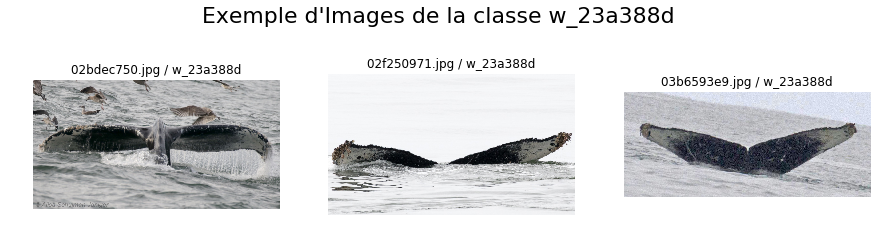

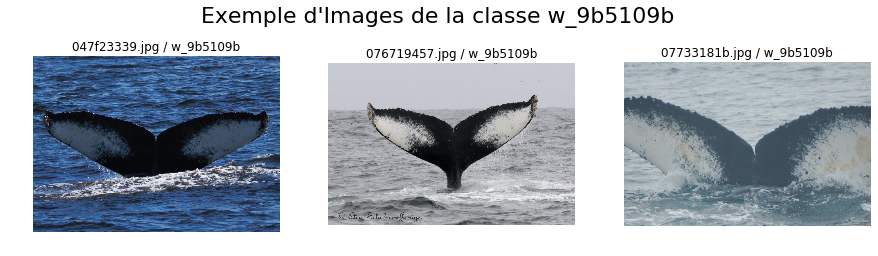

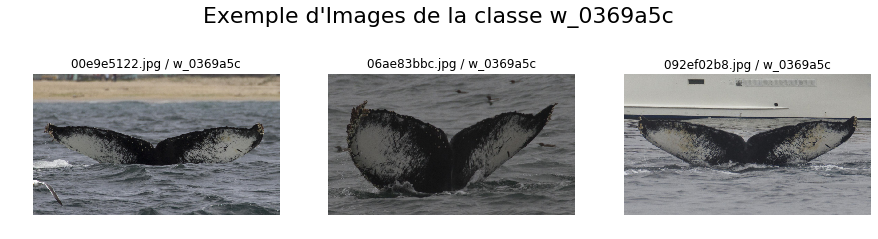

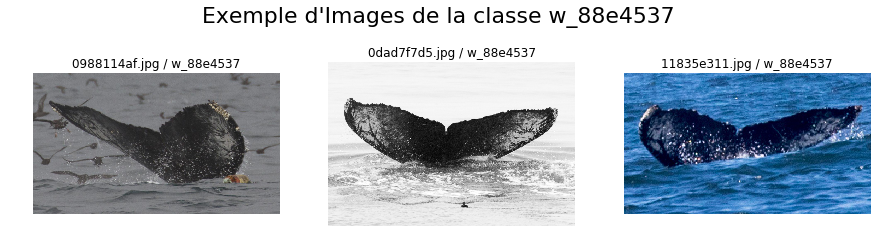

In [305]:
affiche_exemple_image_meme_class(CLASS_NAME = 'w_23a388d')
affiche_exemple_image_meme_class(CLASS_NAME = 'w_9b5109b')
affiche_exemple_image_meme_class(CLASS_NAME = 'w_0369a5c')
affiche_exemple_image_meme_class(CLASS_NAME = 'w_88e4537')

In [12]:
# Nombre d'images pour les classes les plus repr√©sent√©es
Head

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
w_700ebb4      57
w_3de579a      54
w_564a34b      51
w_fd3e556      50
w_88e4537      49
Name: Id, dtype: int64

In [13]:
print('Nombre de classes diff√©rentes : ', df_train.Id.nunique())

Nombre de classes diff√©rentes :  5005


> on remarque une disparit√© tr√®s importante entre la repr√©sentation de 'new_whale' (c'est normal) et les autres

In [64]:
def tag_from_frequence(freq_in):
    if freq_in>=1000: return '[ 80, $\infty$ ['
    elif freq_in>=50: return '[ 50, 80 ['
    elif freq_in>=20: return '[ 20, 50 ['
    elif freq_in>=10: return '[ 10, 20 ['
    elif freq_in>=6: return '[ 6, 10 ['
    elif freq_in>=5: return '[ 5 ]'
    elif freq_in>=4: return '[ 4 ]'
    elif freq_in>=3: return '[ 3 ]'
    elif freq_in>=2: return '[ 2 ]'
    else: return '[ 1 ]'
    
def tag_from_frequence_order(freq_in):
    if freq_in>=1000: return 16
    elif freq_in>=50: return 15
    elif freq_in>=20: return 14
    elif freq_in>=10: return 13
    elif freq_in>=6: return 12
    elif freq_in>=5: return 11
    elif freq_in>=4: return 10
    elif freq_in>=3: return 9
    elif freq_in>=2: return 8
    else: return 0

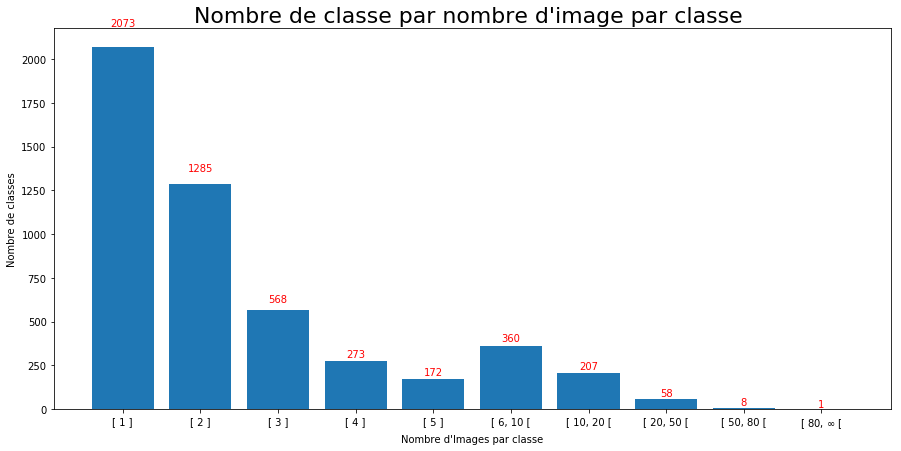

In [65]:
ensembles = [ tag_from_frequence(x) for x in df_train.Id.value_counts().values]
ensembles_ord = [ tag_from_frequence_order(x) for x in df_train.Id.value_counts().values]
t1 = pd.DataFrame({'Ensemble':ensembles, 'Ordre':ensembles_ord})
t2 = t1.groupby(['Ensemble', 'Ordre']).size().reset_index(name='Freq')
t2.sort_values(by=['Ordre'], inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(15, 7, forward=False)
rect1 = plt.bar(x=t2['Ensemble'], height=t2['Freq'], data=t2['Freq'])
plt.title("Nombre de classe par nombre d'image par classe ", fontsize=22)
plt.xlabel("Nombre d'Images par classe")
plt.ylabel("Nombre de classes")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom', color='red')

autolabel(rect1)
plt.show()

<a id='section2'></a>
# Probl√®mes soulev√©s par ce Challenge
-----

<a id='section2.1'></a>
## La probl√©matique G√©n√©rale du KAGGLE
-----
<div class="alert alert-block alert-info">
<b>RAPPEL : </b><br> 
Le d√©p√¥t du r√©sultat se fait sous la forme d'un fichier comprenant pour chaque image √† pr√©dire, une liste de 5 noms de classe de baleine.<br><br> 
Si la bonne classe est identifi√©e, sa place dans la liste de 5 noms propos√©s rapporte plus ou moins de 'points'
La moyenne des points pour l'ensemble des 7 960 images nous donne le score pour le challenge.
</div>

<div class="alert alert-block alert-warning">
<b>A titre d'exemple:</b> Le fichier 'template' de r√©sultat propos√©, comprenant "new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c" comme propositions de noms pour chaque image obtient (√† l'analyse actuelle de 20% des pr√©dictions de notre fichier) un score de 0.277.<br>
-> Sachant que les images labellis√©es 'new_whale' repr√©sentent 38 % des images de training.
</div>

<a id='section2.1.1'></a>
### Strat√©gie Globale
Une strat√©gie globale pour traiter cette probl√©matique peut donc √™tre de 
1. Mod√©liser l'appartenance de chaque image √† une classe plut√¥t qu'√† une autre : probl√©matique de classification
2. Proposer la liste de 5 noms les plus probables (et leur probabilit√© individuelle de pr√©diction)
3. Ordonner la proposition de 5 noms selon ces probabilit√©s, voire selon une 2e v√©rification de ces probabilit√©s
4. La classe 'new_whale' est une classe 'fourre-tout', c'est √† dire qu'on doit y mettre les images qui ne correspondent pas √† la m√™me classe qu'une image d√©j√† vue et labellis√©e<br>
Il semble donc n√©cessaire de comparer les solutions entre 
    1. la d√©tection √† l'appartenance √† cette classe 
    2. la non appartenance √† une autre classe

<a id='section2.1.2'></a>
### Strat√©gies particuli√®res
Afin de suivre la strat√©gie globale pour r√©pondre aux besoins du Challenge j'ai d√©fini 4 strat√©gies qui permettent de mettre de suivre celle-ci.
    1. Mod√©liser la classification (new_whale compris) : 
        -> Donner les 5 meilleurs score dans l'ordre (ou avec une pond√©ration √† d√©finir)
    2. Mod√©liser la classification (new_whale compris) : 
        -> Etablir une notion de distance √† l'appartenance de chaque classe pour ajouter un √©l√©ment 'new_whale' et sa place √† proposer dans la liste des propositions par l'√©tablissement d'un seuil, par clustering, ...
    3. Mod√©liser la classification (en excluant les images labellis√©es 'new_whale') : 
        -> Donner les 5 meilleurs score pour la pr√©diction des images de test, mod√©liser la d√©tection d'appartenance √† 'new_whale' par rapport aux scores des noms propos√©s.
    4. (solution √† pr√©senter apr√®s -- est-ce new_whale ou autre : 
        -> Si c'est autre mod√©liser l'appartenance √† tel ou tel groupe) 

<a id='section2.2'></a>
## Les Difficult√©s li√©es aux donn√©es
------
Pour traiter notre probl√©matique de mod√©lisation de 5005 classes √† partir de ces images, l'utilisation du `DEEP LEARNING` au travers d'un `CNN` ( `Convolutional Neural Network`) ou `R√©seau de Neurones Convolutionnel` semble adapt√©

<a id='section2.2.1'></a>
### Transfer Learning

Nous l'avons vu, la distribution des donn√©es mises √† disposition est d√©sequilibr√©e, 
- 9 660 images en 'new_whale'
- 66 classes ont entre 20 et 80 images
- 2 000 classes n'ont qu'une seule image
- 1 280 classes n'en ont que 2 ...

Il s'agit donc d'un petit dataSet (faible repr√©sentation des classes) pour un grand nombre de classes (5005)<br>

<div class="alert alert-block alert-info">
<b>Solution:</b><br>
-> Une solution adapt√©e pour traiter cela est le `Tranfer Learning`<br>
Consiste √† utiliser un CNN pr√©-entrain√© sur ce m√™me type d'images et donc ayant d√©j√† identifi√© les features (dans les couches basses).<br>
</div>

Nous allons utiliser des CNN entrain√©s sur des images d'ImageNet

<a id='section2.2.2'></a>
### Data Augmentation

Dans le cas de CNN o√π l'on a une faible repr√©sentation de certaines classes un principe est tr√®s utile c'est celui de la `Data Augmentation` qui consiste √† ajouter des images synth√©tiques g√©n√©r√©es via des transformations al√©atoires √† des images existantes.<br>
On peut par exemple faire les transformations suivantes : 
- translations verticales, horizontales
- rotations d'images
- miroring horizontal et vertical 
- modification du contraste de l'image
- zoom avant ou arri√®re
- r√©duction de bruit blanc (zca whitening)

Ainsi on augmente son DataSet de donn√©es nouvelles qui vont am√©liorer les performances de l'entrainement du mod√®le.

<div class="alert alert-block alert-warning">
<b>Dans Keras :</b>  Ces transformations sont facilement r√©alisables par l'utilisation de la classe de pr√©-processing `ImageDataGenerator`<br>
Il suffit de param√©trer pour la plupart des param√®tres de d√©finir un interval de valeurs de tranformations.<br><br>
- Les images synth√©tiques sont g√©n√©r√©es √† la vol√©e √† chaque appel d'utilisation d'une image pour l'entrainement (et on peut aussi le faire pour la phase de validation et de test)<br>
- Ainsi pour la rotation par exemple on donnera l'angle en degr√©s $\alpha$ et donc de fa√ßon al√©atoire les images seront tourn√©es d'un angle compris dans [ - $\alpha$ ; + $\alpha$ ]<br>
- Chaque transformation sera r√©alis√©e en m√™me que les autres, avec des valeurs al√©atoires ind√©pendantes entre elles dans la limite de ce qui a √©t√© param√©tr√©.
</div>




#### Exemple de Data Augmentation

In [5]:
# Definition du ImageDataGenerator c'est √† dire les param√®tres des transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.40, 0.8],
    zoom_range=[0.7, 1.7],
)

<div class="alert alert-block alert-warning">
Ici nous ne r√©alisons pas de miroring vertical car les images sont dans le bon sens et on ne trouve pas d'images √† l'envers (le ciel en bas)
</div>

In [6]:
MyTransformation = TransformImage(train_datagen, resize_max_pixel=300000, 
                   dir_input=dir_image_train, dir_output=dir_image_train, 
                   prefix_rename='AUG')

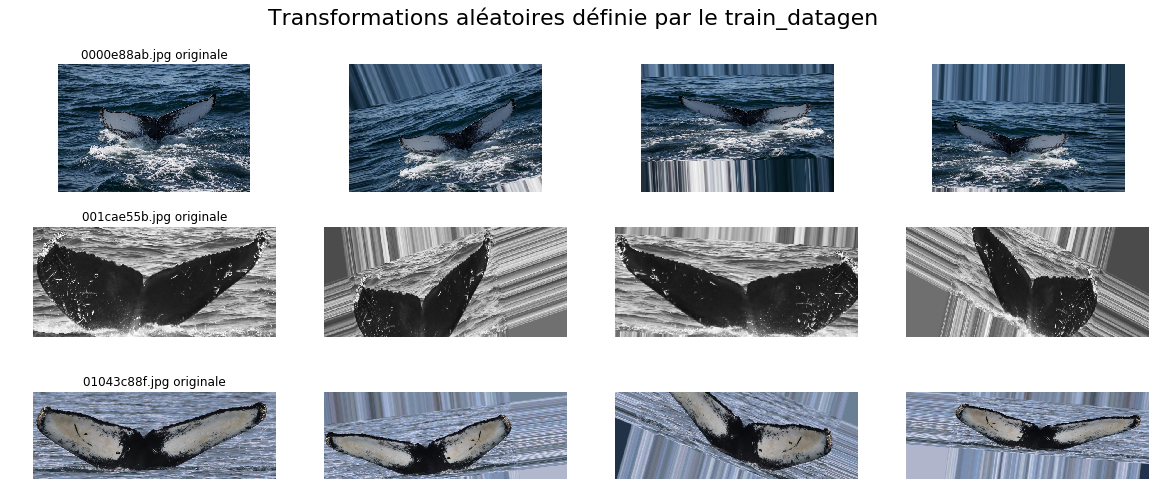

In [66]:
def affiche_transformation(l_index_image_dataSet):
    fig, ax = plt.subplots(3, 4, )
    ax = ax.ravel()
    fig.set_size_inches(20, 8, forward=True)
    #l_index_image_dataSet = [0, 10, 100, 4000, 12000, 13000, 13001, 13002, 13003]
    idx_axe = 0

    for idx, idx_image in enumerate(l_index_image_dataSet):
        image_name = get_image_name_id_from_index(idx_image)
        ax[idx_axe].imshow(image_with_index(idx_image))
        ax[idx_axe].axis('off')
        ax[idx_axe].set_title('{} originale'.format(image_name))
        idx_axe+=1

        for i in range(3):
            ax[idx_axe].imshow(np.array(MyTransformation.transform(filename=image_name)))
            ax[idx_axe].axis('off')
            idx_axe+=1
    plt.suptitle('Transformations al√©atoires d√©finie par le train_datagen', fontsize=22)
    plt.show()

affiche_transformation([0, 10, 100, ])

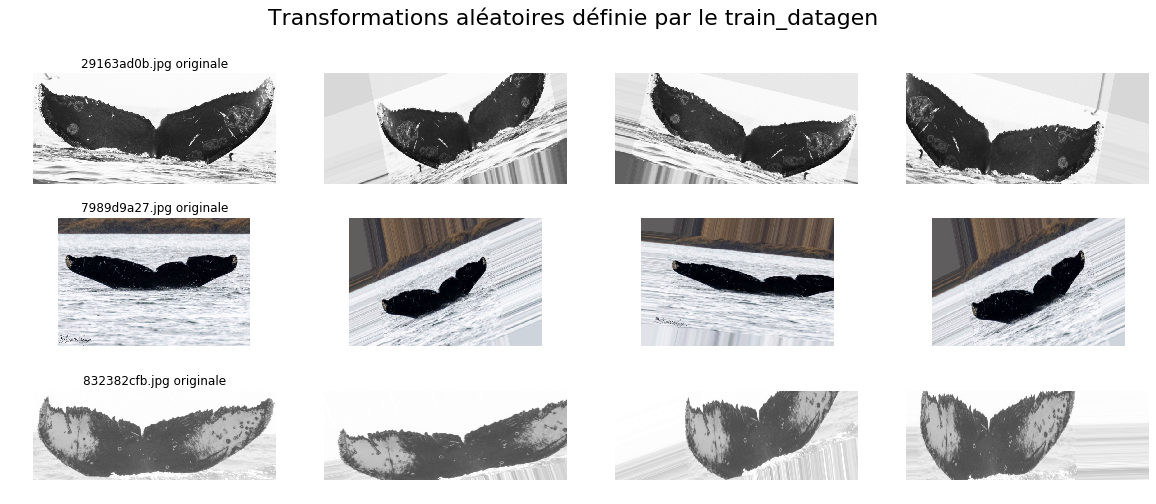

In [67]:
affiche_transformation([4000, 12000, 13000])

#### Tr√®s tr√®s peu d'Images

Nous avons aussi remarqu√© que de tr√®s nombreuses classes n'ont qu'une image, ou seulement 2 ou 3, ce qui est tr√®s peu.<br>
Un probl√®me qui se pose notamment (en plus de la difficult√© √† optimisser la performance) est qu'il n'est m√™me pas possible de r√©aliser les diff√©rentes phases que sont l'entrainement / la validation et optimisation et le test de performance du mod√®le avec si peu de donn√©es.

<div class="alert alert-block alert-info">
<b>Solution:</b> Dans ce cas aussi nous allons utiliser la `Data Augmentation` √† partir des images peu repr√©sent√©es. Les images ainsi g√©n√©r√©es seront ajout√©es au DataSet des images √† utiliser.
</div>

#### Code de G√©n√©ration des Images par Data Augmentation

```python

def genere_list_name_from_a_class(name, df, nb_to_create=5):
    '''G√©n√©ration d'un DataFrame avec le nom des image √† dupliquer'''
    l1 = list(df[df.Id==name].Image.values)*nb_to_create
    # On laisse jouer le random pour permuter les listes
    shuffle(l1)
    df_tmp = pd.DataFrame({'Image': l1[:nb_to_create]})
    df_tmp['Id'] = name
    return df_tmp

def create_df_with_image_to_augment(df_in, min_occurence=6):
    # On identifie l'occurrence de chaque classe
    frequences = df_in.Id.value_counts()
    
    # On ne traite que celles manquant d'images
    df_to_treat = frequences[frequences.values<min_occurence]
    
    l_df_with_names = []
    
    # On lance la g√©n√©ration d'image classe par classe
    for name, nb_occ in zip(df_to_treat.index, df_to_treat.values):
        tmp_df = genere_list_name_from_a_class(
            name, 
            df_in, 
            nb_to_create=min_occurence-nb_occ)
        l_df_with_names.append(tmp_df)
     
    # On renvoie le dataframe g√©n√©r√©
    return pd.concat(l_df_with_names).reset_index(drop=True)

def genere_image_aug(df_in, myImageDataGenerator, min_occurence=6):
    '''Fonction qui 
    - recupere la liste des images a dupliquer
    - genere les nouvelles images
    - renvoie un dataframe avec les nouveau nom et les Id
    '''
    
    # Liste des images √† dupliquer
    new_dataframe = create_df_with_image_to_augment(df_in, min_occurence=6)
    
    # Les Paths
    path_in='./../DATAS/data/train'
    path_out = './../DATAS/data/aug'

    # On Initialise la classe de tranformation des Images
    MyTransformation = TransformImage(
        train_datagen, 
        resize_max_pixel=300000, 
        dir_input=path_in, 
        dir_output=path_out, 
        prefix_rename='AUG')

    idx_nb_traite = 0
    l_new_name = []
    # On lance la transformation des Images
    for m_name, m_class in zip(new_dataframe.Image, new_dataframe.Id):
        idx_nb_traite+=1
        # Transformation al√©atoire de l'image et sauvegarde 
        new_name = MyTransformation.transform_and_save(filename=m_name)
        l_new_name.append(new_name)
        
    return pd.DataFrame({'Image': l_new_name, 'Id': new_dataframe.Id})    

## Execution de la g√©n√©ration des Images
df_image_aug = genere_image_aug(df_train, train_datagen, min_occurence=6)

```

<a id='section3'></a>
# La Mod√©lisation
-----

<a id='section3.1'></a>
## CNN

Comme nous l'avons dit nous utilisons un r√©seau convolutionel de neurones pour faire la classification de nos images.

Nous utilisons ici une solution de `Transfer Learning` √† partir du VGG16 pr√©-entrain√© sur les images d'ImageNet (base d'Images initi√©e par l'√©quipe de <b>Li Fei-Fei</b> de l'Universit√© de Stanford).

![VGG16](Images/vgg16.png "VGG16")

Des tests ont aussi √©t√© r√©alis√©s via InceptionV3. 

<a id='section3.2'></a>
## Process

Nous s√©parons les donn√©es de train en 3 parties : `train (60%) / validation (20%) / split (20%`<br>
√† l'aide de la fonction train_test_split par stratification, ce qui permet de ne pas avoir de classes non vues dans le train ou la validation ainsi que le fait de pouvoir tester toutes les classes.<br>

Nous passons ces ensembles dans un `ImageDataGenerator`, dans lequel nous appliquons de la Data Augmentation pour les donn√©es de Train, et rescallons toutes les donn√©es entre [0, 1]<br>

Les donn√©es alimentent ensuite le CNN apr√®s avoir √©t√© resiz√©es en (224, 224) pour l'entr√©e dans le r√©seau de neurones.



<a id='section3.3'></a>
## Pr√©-Traitement sur les Images

Il est √† noter que certaines images sont en niveau de gris (255 nuances de gris) et non en RGB.<br>
Cette op√©rations peut √™tre r√©alis√©e en pr√©processing par le g√©n√©rateur d'images.

De plus nous savons que pour l'insertion dans le r√©seau de neurones les images vont √™tre redimensionn√©es.

L'entrainement des r√©seaux s'av√®re tr√®s lourd et co√ªteux en ressources et en temps.

Aussi afin de r√©duire un peu le temps d'entrainement les images ont toutes √©t√© modifi√©es 'une fois pour toute' afin de gagner du temps au chargement d'images sur des tailles que de toute fa√ßon nous savons que nous allons diminuer √† chaque √©tape.

L'op√©ration aurait p√ª √™tre r√©alis√©es en python mais l'a √©t√© manuellement √† partir de `convert` d'`Image Magick`
```bash 
ls $rep_in | while read toto
	do 
    convert -colorspace Gray $rep_in/$toto -resize 100000@ $rep_out/$toto 
    done
```
L'option -resize 100000@ appliquant un redimensionnement (conservant la r√©solution) tel que le nombre de pixels ne d√©passe pas 100 000<br>
Les images sont donc toutes transform√©es en niveau de gris

<a id='section4'></a>
# Les R√©sultats de la mod√©lisation
-----

<a id='section4.1'></a>
## L'entrainement

Les donn√©es ont √©t√© entrain√©es sur un serveur `p2.xlarge` chez `AWS EC2`.

Pour un nombre d'EPOCH allant jusqu'√† 50 avec un nombre r√©duit d'images les temps de traitement ont √©t√© de 7h avec l'usage de GPU



<a id='section4.2'></a>
## Les R√©sultats

La mod√©lisation de classification n'a pas donn√© de r√©sultats satisfaisant.<br>
En effet l'accuracy relev√©e √©tait tr√®s basse aux alentours de `acc: 0.1562` et les valeurs d'accuracy de validation restait autour de `val_acc: 2.1580e-04` sans √©volution.

- Ce probl√®me qui peut √™tre li√© √† un probl√®me de learning rate n'a pas √©t√© corrig√© par le test de diff√©rentes valeurs de lr et diff√©rents optimizer ont √©t√© benchmark√©s : RMSprop / Adam et SGD sans meilleur succ√©s

In [80]:
import json

file1 = './AWS_JEUDI/GOOD/3_2_history_gpu_history.json'
file3 = './AWS_JEUDI/output/3_9_bis_INCEPTION_V3_history_gpu_history.json'

with open(file1, 'r') as f: data1 = json.loads(f.read())
with open(file3, 'r') as f: data3 = json.loads(f.read())
    
def affiche_graph(data, titre=''):
    def affiche_one(data, d_param):
        plt.plot(data[d_param['x_key']])
        plt.plot(data[d_param['y_key']])
        plt.title('model {}'.format(d_param['type_model']))
        plt.ylabel(d_param['type_model'])
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

    plt.figure(figsize=(15, 7), )
    plt.subplot(121)
    affiche_one(data, {'x_key': 'acc', 'y_key': 'val_acc', 'type_model': 'accuracy'})
    
    plt.subplot(122)
    affiche_one(data, {'x_key': 'loss', 'y_key': 'val_loss', 'type_model': 'loss'})
    plt.suptitle(titre, fontsize=12)
    plt.show()


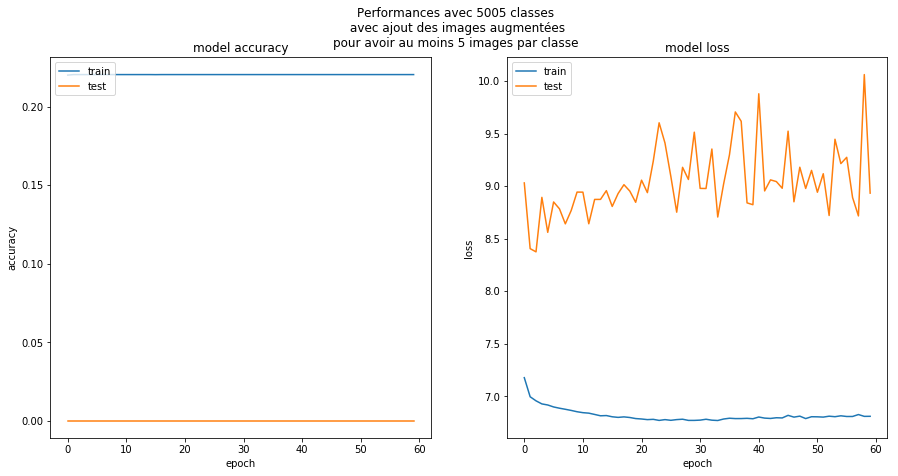

In [81]:
affiche_graph(data1, titre="Performances avec 5005 classes\n"
              " avec ajout des images augment√©es\n"
              "pour avoir au moins 5 images par classe")

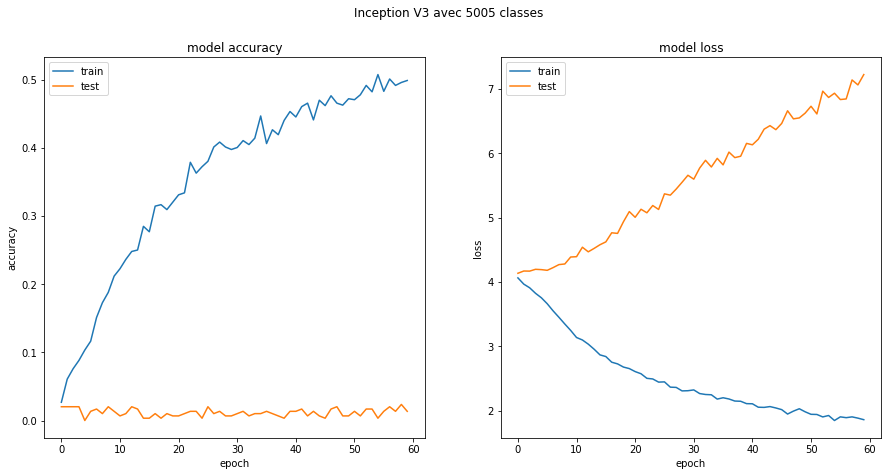

In [82]:
affiche_graph(data3, 'Inception V3 avec 5005 classes')

<a id='section4.3'></a>
## Faux Bon r√©sultat

> Dans un but de tester le mod√®le sur des donn√©es qui permettent de montrer la performance dans certaines conditions (afin de v√©rifier qu'il n'y a pas de bug) un filtrage a √©t√© r√©alis√© sur les donn√©es.

> Seules les classes ayant plus de 20 images sont prises en compte : cela concerne 60 classes diff√©rentes.

> A la suite de l'entrainement une accuracy de 0.83 a √©t√© obtenue pour l'entrainement comme la validation apr√®s 2 ECOCH.  ü§ó


![](Images/3_9.png "Version 3.9")

#### Analyse de la pr√©diction des donn√©es de test

In [109]:
file_test_9 = './AWS_JEUDI/output/3_9_BIS_DF_TEST_PREDICTION.csv'
file_prediction_challenge_9 = './AWS_JEUDI/output/3_9_BIS_DF_PREDICTION_CHALLENGE.csv'
file_test_11 = './AWS_JEUDI/output/3_11_DF_TEST_PREDICTION.csv'

df_test_9 = pd.read_csv(file_test_9, index_col=[0])
df_challenge_9 = pd.read_csv(file_prediction_challenge_9, index_col=[0])
df_test_11 = pd.read_csv(file_test_11, index_col=[0])


In [89]:
df_test_9.head()

new_whale  w_789c969  w_fd3e556  w_e1ffbe2  w_ef83760  \
4ced78cca.jpg   0.782884   0.002174   0.002813   0.002384   0.002800   
b8de9430a.jpg   0.885274   0.001179   0.000877   0.001003   0.001705   
9fd6630a9.jpg   0.803480   0.001991   0.001523   0.002899   0.002318   
57aabaa94.jpg   0.740258   0.002650   0.003231   0.002587   0.004099   
b7decf2d2.jpg   0.857055   0.001632   0.001212   0.001616   0.002468   

               w_5a2634c  w_5773c71  w_51fc1fc  w_f0fe284  w_564a34b  \
4ced78cca.jpg   0.004754   0.002783   0.006390   0.006073   0.004168   
b8de9430a.jpg   0.001725   0.002122   0.001864   0.002339   0.001704   
9fd6630a9.jpg   0.005410   0.002404   0.004825   0.003030   0.003574   
57aabaa94.jpg   0.005401   0.003328   0.004338   0.005931   0.003419   
b7decf2d2.jpg   0.002433   0.001399   0.003866   0.003198   0.001993   

                   ...        w_08630fd  w_1ca9ab1  w_8da30ad  w_60cf87c  \
4ced78cca.jpg      ...         0.002318   0.003421   0.003646   0.003226   
b8de9430a.jpg      ...         0.002087   0.001897   0.001656   0.001820   
9fd6630a9.jpg      ...         0.002636   0.003457   0.002010   0.004248   
57aabaa94.jpg      ...         0.004492   0.003324   0.004062   0.005406   
b7decf2d2.jpg      ...         0.002317   0.002552   0.001532   0.002435   

               w_343f088  w_bfcad53  w_75f6ffa  w_0bc078c  Real_Class_Name  \
4ced78cca.jpg   0.003159   0.003072   0.002068   0.002135        new_whale   
b8de9430a.jpg   0.001382   0.001277   0.001172   0.001258        w_789c969   
9fd6630a9.jpg   0.003873   0.002312   0.002415   0.002939        new_whale   
57aabaa94.jpg   0.004554   0.004593   0.002664   0.004295        new_whale   
b7decf2d2.jpg   0.001714   0.002078   0.001218   0.001678        new_whale   

               Real_Class_Id  
4ced78cca.jpg              0  
b8de9430a.jpg              1  
9fd6630a9.jpg              0  
57aabaa94.jpg              0  
b7decf2d2.jpg              0  

[5 rows x 62 columns]

#### Fonction de Mesure d'une liste propos√©e pour une Image

<div class="alert alert-block alert-warning">
<b>Rappel de la formule de mesure</b>
$$MAP@5=\frac{1}{U}\sum_{u=1}^{U}\sum_{k=1}^{min(n,5)}P(k)√órel(k)$$<br>
</div>

In [91]:
def get_score_from_list(name_good_class, l_prediction):
    if name_good_class in l_prediction[:5]:
            return 1/(l_prediction.index(name_good_class)+1)
    else:
        return 0

#### Mesure d'une pr√©diction (√† partir du label) par pourcentage de probabilit√© de pr√©diction

In [98]:
def get_mesure(df_test, threshold):
    '''
    D√©termine la moyenne des MAP@5
    INPUT: 
        - df_test : le DataSet pr√©dit √† partir des donn√©es de test
        - threshold : seuil obtenu par 'new_whale' √† partir duquel on met 'new_whale' en 1e position de la liste.
    '''
    l_col = list(df_test.columns)[:-2]

    id_2_name = dict()
    for nb, name in enumerate(l_col):
        id_2_name[nb] = name
    
    matrice = df_test.values[:, :-2]
    
    resultat_indices_meilleurs = np.argsort(matrice, axis=1)[::-1][:,:5]
    resultat_valeurs_meilleurs = np.sort(matrice, axis=1)[::-1][:,:5]

    l_res = []
    for i, val_new_whale in zip(resultat_indices_meilleurs, df_test['new_whale'].values):
        tmp1 = [id_2_name[x] for x in i]
        if (val_new_whale>threshold):
            tmp1 = ['new_whale'] + tmp1
        l_res.append(tmp1)

    y = list(df_test['Real_Class_Name'].values)

    l_mesure = []
    for good, predict in zip(y, l_res):
        l_mesure.append(get_score_from_list(good, predict))

    return np.mean(l_mesure)

Les mesures pour des threshold de 0.0, 0.9 et 1.0

In [113]:
get_mesure(df_test_9, 0.0), get_mesure(df_test_9, 0.9), get_mesure(df_test_9, 1.0),

(0.83480251860332, 0.03116771608471666, 0.008271322266742988)

#### Comparaison du score de test selon le threshold

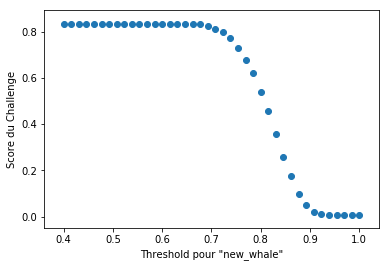

CPU times: user 1.53 s, sys: 3.98 ms, total: 1.53 s
Wall time: 1.53 s


In [116]:
%%time 

m_res = []
m_x = np.linspace(0.4, 1.0, num=40)
for i in m_x:
    m_res.append(get_mesure(df_test_9,i))
    
plt.scatter(x=m_x, y=np.array(m_res))
plt.xlabel('Threshold pour "new_whale"')
plt.ylabel('Score du Challenge')
plt.show()

> Dans ce cas de mod√©lisation le seuil doit √™tre fix√© √† 0.0 pour obtenir la meilleure note de 0.83.<br>
> Cela signifie donc que par rapport √† la pr√©diction des donn√©es seule compte le fait de forcer la place de 'new_whale' en 1e place de la liste des proposition de toutes les lignes.

En regardant les donn√©es utilis√©es pour cet entrainement nous voyons

In [190]:
df_reparition_classes = df_train.Id.value_counts()
df_nb_plus_de_20_images = df_reparition_classes[df_reparition_classes>20]
pd.DataFrame({"Nombre d'images":df_nb_plus_de_20_images})[:5]

Nombre d'images
new_whale             9664
w_23a388d               73
w_9b5109b               65
w_9c506f6               62
w_0369a5c               61

In [191]:
l_df_image_ok = []
for image_name in df_nb_plus_de_20_images.index:
    l_df_image_ok.append(df_train[df_train.Id==image_name])

df_classes_avec_beaucoup_images = pd.concat(l_df_image_ok)

In [193]:
df_classes_avec_beaucoup_images.head()

Image         Id
3   00050a15a.jpg  new_whale
4   0005c1ef8.jpg  new_whale
5   0006e997e.jpg  new_whale
7   000f0f2bf.jpg  new_whale
11  001d7450c.jpg  new_whale

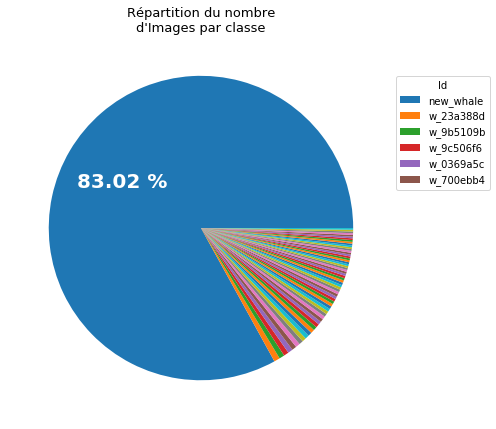

In [198]:
t6 = df_classes_avec_beaucoup_images.Id.value_counts()

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    if pct>10:
        return "{:.2f} %".format(pct)
    else: 
        return None

wedges, texts, autotexts = ax.pie(t6, autopct=lambda pct: func(pct, t6),
                                  textprops=dict(color="w"))

ax.legend(wedges, t6[t6.values>55].index,
          title="Id",
          loc="center left",
          bbox_to_anchor=(1, 0, 2.0, 1.5))

plt.setp(autotexts, size=20, weight="bold")

ax.set_title("R√©partition du nombre\nd'Images par classe", fontsize=13)

plt.show()

> En fait les 83 % d'accuracy semblent tr√®s li√©s √† la proportion des image de classe 'new_whale' par rapport aux autres images dans les donn√©es en entr√©es de la mod√©lisation

In [261]:
def get_confusion_matrix(df_test):
    '''
    D√©termine le label obtenant la meilleure probabilit√© de pr√©diction
    et renvoie la matrice de confusion 
    '''
    from sklearn.metrics import confusion_matrix
    l_col = list(df_test.columns)[:-2]

    id_2_name = dict()
    for nb, name in enumerate(l_col):
        id_2_name[nb] = name
    
    matrice = df_test.values[:, :-2]
    resultat_indices_meilleurs = np.argsort(matrice, axis=1)[::-1][:,0]    
    y_predict = np.array([id_2_name[i] for i in resultat_indices_meilleurs])
    y_true = df_test.Real_Class_Name.values
    
    cm = pd.DataFrame(confusion_matrix(y_true, y_predict))
    cm.columns = df_test.columns[:-2]
    cm.index = df_test.columns[:-2]
    
    return cm

In [264]:
cm_from_test_9 = get_confusion_matrix(df_test_9)

In [265]:
cm_from_test_9.head()

new_whale  w_789c969  w_fd3e556  w_e1ffbe2  w_ef83760  w_5a2634c  \
new_whale          0          1          0          1          3          5   
w_789c969          0          0          0          0          0          0   
w_fd3e556          0          0          0          0          0          0   
w_e1ffbe2          0          0          0          0          0          0   
w_ef83760          0          0          0          0          0          0   

           w_5773c71  w_51fc1fc  w_f0fe284  w_564a34b    ...      w_6caff0f  \
new_whale        101          0          0         17    ...              0   
w_789c969          1          0          0          0    ...              0   
w_fd3e556          1          0          0          0    ...              0   
w_e1ffbe2          1          0          0          0    ...              0   
w_ef83760          1          0          0          0    ...              0   

           w_27597ff  w_08630fd  w_1ca9ab1  w_8da30ad  w_60cf87c  w_343f088  \
new_whale         86          3         12          8          0          0   
w_789c969          0          0          0          0          0          0   
w_fd3e556          0          0          0          0          0          0   
w_e1ffbe2          0          0          0          0          0          0   
w_ef83760          0          0          0          0          0          0   

           w_bfcad53  w_75f6ffa  w_0bc078c  
new_whale         27         68          0  
w_789c969          0          0          0  
w_fd3e556          0          0          0  
w_e1ffbe2          0          0          0  
w_ef83760          0          0          0  

[5 rows x 60 columns]

In [281]:
# Les classes les plus pr√©sentes dans les donn√©es pr√©dites
np.sum(cm_from_test_9, axis=0).sort_values(ascending=False).head(10)

w_700ebb4    433
w_cd4cb49    207
w_9da1811    189
w_5773c71    135
w_27597ff    103
w_9c506f6     89
w_4516ff1     89
w_2b069ba     84
w_75f6ffa     82
w_17b0d3a     73
dtype: int64

In [282]:
# Les classes les plus pr√©sentes dans les donn√©es de test sont
np.sum(cm_from_test_9, axis=1).sort_values(ascending=False).head(10)

new_whale    1450
w_f765256      11
w_990921b      10
w_04003e9      10
w_bc285a6       9
w_fd3e556       9
w_efbdcbc       8
w_75f6ffa       8
w_0369a5c       8
w_9c506f6       8
dtype: int64

> En fait aucune 'new_whale' n'a √©t√© pr√©dite 

<a id='section5'></a>
# CONCLUSION

La mod√©lisation de classification par Transfer Learning n'a ici rien donn√© du fait des faibles scores obtenus.<br>
Cette √©tape √©tant n√©cessaire (par rapport √† la strat√©gie propos√©e) pour l'√©laboration d'une liste de pr√©diction, la suite de l'analyse n'a malheureusement pas pu aller plus loin.

Par la suite il faut identifier pour quelles raisons celle-ci n'a pas donn√© de r√©sultat:
- la piste est √† priori l'id√©e erron√©e que les r√©seaux choisis connaissent d√©j√† les images de Baleines.
-> certe il y a des sections Baleine mais il n'est ) post√©riori pas s√ªr que celles-ci soient faite sur des d√©tails de la queue des baleine.
- actuellement le site ImageNet est en maintenance et il ne m'a pas √©t√© possible de v√©rifier cela
- la solution pour reprendre la mod√©lisation aurait donc √©t√© d'entrainer plus de niveaux (et pas uniquement celui de classification tel que cela a √©t√© fait) 


Ces doutes √©tant apparus tardivement (apr√®s plusieurs essais longs de mod√©lisation) il ne semblait plus possible d'envisager cet entrainement suppl√©mentaire.